In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import mir_eval
import scipy
import librosa
import tqdm
import copy

import models
import datasets
import oracles
import metrics
import utils
import change_point_detection as cpd
import query_strategies as qs
import evaluate
import visualize

import metrics

import matplotlib.pyplot as plt
import matplotlib

In [38]:
models.binary_entropy(1.0 - 1e-15)

5.123178885069411e-14

In [12]:
pos_ref = [(7.20, 7.34), (9.74, 9.87), (13.92, 14.12)]
pos_pred = [(6.29, 8.57), (8.57, 9.86), (13.86, 14.14)]

min_iou = 0.3
print(metrics.f1_score_from_events(pos_ref, pos_pred, min_iou=min_iou))
print(metrics.average_matched_iou(pos_ref, pos_pred, min_iou=min_iou))

0.3333333333333333
0.7142857142857089


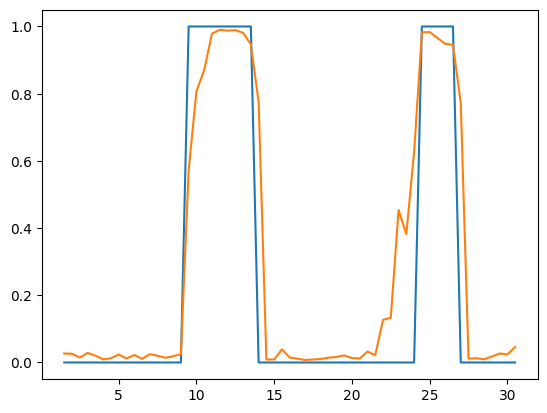

In [4]:
snr = '10.0'
base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_soundscapes_snr_{}/'.format(snr)
soundscape_basename = 'soundscape_0'

oracle = oracles.WeakLabelOracle(base_dir)

# load initial queries and embeddings
queries, embeddings = datasets.load_timings_and_embeddings(base_dir, soundscape_basename)
ts = np.mean(queries, axis=1)

# label the embeddings
labels = []
for (s, e) in queries:
    c = oracle.query(s, e, soundscape_basename)
    labels.append(c)
labels = np.array(labels)

n_embeddings = embeddings[labels == 0]
p_embeddings = embeddings[labels == 1]

# initialize the active learner
adaptive_query = models.AdaptiveQueryStrategy(base_dir)
adaptive_query.update(p_embeddings=p_embeddings, n_embeddings=n_embeddings)

probas = adaptive_query.predict_probas(embeddings)

plt.plot(ts, labels)
plt.plot(ts, probas)

al_queries :  ['(0.00, 5.50)', '(5.50, 11.50)', '(11.50, 12.50)', '(12.50, 15.50)', '(15.50, 22.50)', '(22.50, 24.50)', '(24.50, 30.50)']
pos_ref :  ['(7.20, 7.34)', '(9.74, 9.87)', '(13.92, 14.12)']
(5.5, 12.5)
pos_pred :  ['(5.50, 11.50)', '(12.50, 15.50)']
peaks:  [(3.0, 0.013875731039904415), (5.0, 0.012352031740260665), (6.0, 0.1103050448460764), (7.0, 0.06734389727224044), (8.5, 0.0008925245322939368), (10.0, 0.03769298910795238), (11.0, 0.5908265950788565), (13.0, 0.9568433153524825), (14.0, 0.11294672136846584), (15.0, 0.03463207160694626), (19.5, 0.009231184716751134), (21.0, 0.01071536152237115), (23.0, 0.07179649320755854), (24.0, 0.5243285784693164), (28.0, 0.0029035579544628813), (29.5, 0.0027059232913210704)]
((12.703736556698765, 15.52414062877847), (9.128644086724526, 11.1), (23.653254958912214, 24.347211333404097))


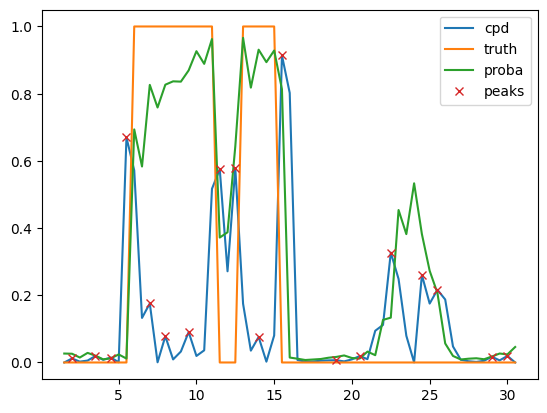

In [5]:
soundscape_basename = 'soundscape_1'

oracle = oracles.WeakLabelOracle(base_dir)

# load initial queries and embeddings
queries, embeddings = datasets.load_timings_and_embeddings(base_dir, soundscape_basename)
ts = np.mean(queries, axis=1)

# label the embeddings
labels = []
for (s, e) in queries:
    c = oracle.query(s, e, soundscape_basename)
    labels.append(c)
labels = np.array(labels)


pos_ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
pos_ref = datasets.load_pos_ref(pos_ref_path)


probas = adaptive_query.predict_probas(embeddings)
al_queries = adaptive_query.predict_queries(soundscape_basename, n_queries=7)

utils.print_queries(al_queries, 'al_queries')
utils.print_queries(pos_ref, 'pos_ref')

pos_pred = oracle.pos_events_from_queries(al_queries, soundscape_basename)

pos_starts, pos_ends = list(zip(*pos_pred))
print(pos_starts)
utils.print_queries(pos_pred, 'pos_pred')


from scipy.signal import chirp, find_peaks, peak_widths
from scipy.interpolate import interp1d

peaks, info = find_peaks(probas, prominence=0)
(widths, width_heights, left_ips, right_ips) = peak_widths(probas, peaks, rel_height=0.2)

# remap
m = interp1d([0, len(probas)-1], [ts[0], ts[-1]])
starts = m(left_ips)
ends   = m(right_ips)

queries = list(zip(starts, ends))

peak_prominences = info['prominences']

print("peaks: ", list(zip(ts[peaks], peak_prominences)))

# rank by prominence
_, ranked_queries = list(zip(*sorted(list(zip(peak_prominences, queries)), key=lambda x: x[0], reverse=True)))

print(ranked_queries[:3])

# change-point detection on probas
probas = probas.reshape((len(probas), 1))
ds = cpd.distance_past_and_future_averages(probas, cpd.euclidean_distance_score, offset=0, M=1)
peaks, _ = find_peaks(ds)

plt.plot(ts, ds, label='cpd')
plt.plot(ts, labels, label='truth')
plt.plot(ts, probas, label='proba')
plt.plot(ts[peaks], ds[peaks], "x", label='peaks')
#plt.hlines(width_heights, starts, ends, color="magenta", label='widths')
#plt.hlines(ts[peaks], *results_full[1:], color="C3")
plt.legend()
plt.show()

In [147]:
len(probas)

59

In [44]:
# TODO: think about events that enter gradually and exit gratually. E.g., car passing by

[29. 32.]


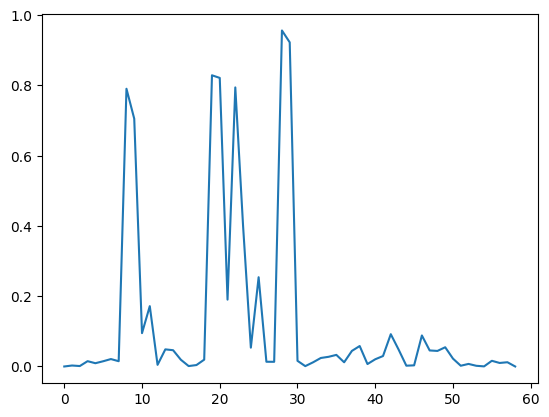

In [122]:
plt.plot(ds)
print(ts[-1])

In [104]:
ls = []
for idx_soundsape in range(n_soundscapes):
    # ACTIVE LEARNER
    base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_soundscapes_snr_{}/'.format(snr)
    soundscape_basename = 'soundscape_{}'.format(idx_soundsape)
    ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
    pos_refs = datasets.load_pos_ref(ref_path)
    for (s, e) in pos_refs:
        l = e-s
        ls.append(l)
print(np.mean(ls))
print(np.min(ls))
print(np.max(ls))

0.1484333333333334
0.1039999999999992
0.2010000000000005


In [132]:
def list_difference(l1, l2):
    return list(set(l1).difference(l2))

list_difference(['hello', 'there', 'now'], ['there'])

['now', 'hello']

In [133]:
def simulate_strategy(query_strategy, soundscape_basenames, n_queries, base_dir, min_iou):
    next_soundscape_basename = query_strategy.next_soundscape_basename(soundscape_basenames)
    
    # evaluate label-quality and get embeddings
    f1_score, mean_iou_score, p_embeddings, n_embeddings = evaluate.evaluate_query_strategy(
        base_dir            = base_dir,
        soundscape_basename = next_soundscape_basename,
        query_strategy      = query_strategy,
        n_queries           = n_queries,
        min_iou             = min_iou
    )

    soundscape_basenames_remaining = list_difference(soundscape_basenames, [next_soundscape_basename])

    query_strategy.update(p_embeddings, n_embeddings)
    
    return f1_score, mean_iou_score, p_embeddings, n_embeddings, soundscape_basenames_remaining

In [147]:

# NOTE: the embedding function is bound to 3 second resolution
#       setting n_queries > 10 means that the fixed queries are
#       below 3 seconds, and since the CPD is not able to resolve
#       peaks below 3 seconds it will be at a great disadvantage.
#       Up to 3 seconds we see that this works fairly well.

snr = '10.0'
n_soundscapes = 50
max_queries   = 10

#n_queriess = np.arange(3, max_queries+1)
n_queriess = [5] #[3, 7, 10] #[3, 5, 7, 9, 10] #, 55]
print("n_queriess: ", n_queriess)

base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me/train_soundscapes_snr_{}/'.format(snr)

n_soundscapes_budget = 10 #n_soundscapes-1
min_iou = 0.00001

n_init_soundscapes = 10

for n_queries in n_queriess:
    init_soundscape_basenames = np.random.choice(['soundscape_{}'.format(idx) for idx in range(n_soundscapes)], n_init_soundscapes)

    # label-quality scores
    s0_scores = []
    s1_scores = []
    s2_scores = []
    s3_scores = []
    
    for init_soundscape_basename in tqdm.tqdm(init_soundscape_basenames):
        # query strategies
        query_strategy_0 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=False, fixed_queries=False)
        query_strategy_1 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=False)
        query_strategy_2 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=False, fixed_queries=True)
        query_strategy_3 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=True)
        
        # initialize strategies with ground truth labels for supplied soundscape
        query_strategy_0.initialize_with_ground_truth_labels(init_soundscape_basename)
        query_strategy_1.initialize_with_ground_truth_labels(init_soundscape_basename)
        query_strategy_2.initialize_with_ground_truth_labels(init_soundscape_basename)
        query_strategy_3.initialize_with_ground_truth_labels(init_soundscape_basename)

        remaining_soundscape_basenames = list_difference(all_soundscape_basenames, [init_soundscape_basename])
        remaining_soundscape_basenames = sorted(remaining_soundscape_basenames)
        np.random.shuffle(remaining_soundscape_basenames)

        bns_s0 = copy.copy(remaining_soundscape_basenames)
        bns_s1 = copy.copy(remaining_soundscape_basenames)
        bns_s2 = copy.copy(remaining_soundscape_basenames)
        bns_s3 = copy.copy(remaining_soundscape_basenames)
        
        # label the soundscapes using budget
        budget_count = 0
        while budget_count < n_soundscapes_budget:
        #for soundscape_basename in remaining_soundscape_basenames:

            ######################################################################################
            # Strategy 0: active query strategy, and active soundscape strategy
            ######################################################################################
            s0_f1_score, s0_mean_iou_score, _, _, bns_s0 = simulate_strategy(
                query_strategy       = query_strategy_0,
                soundscape_basenames = bns_s0,
                n_queries            = n_queries,
                base_dir             = base_dir,
                min_iou              = min_iou
            )

            s0_scores.append((s0_f1_score, s0_mean_iou_score))

            ######################################################################################
            # Strategy 1: active query strategy, and random soundscape strategy
            ######################################################################################
            s1_f1_score, s1_mean_iou_score, _, _, bns_s1 = simulate_strategy(
                query_strategy       = query_strategy_1,
                soundscape_basenames = bns_s1,
                n_queries            = n_queries,
                base_dir             = base_dir,
                min_iou              = min_iou
            )

            s1_scores.append((s1_f1_score, s1_mean_iou_score))

            ######################################################################################
            # Strategy 2: fixed query strategy, and active soundscape strategy
            ######################################################################################
            s2_f1_score, s2_mean_iou_score, _, _, bns_s2 = simulate_strategy(
                query_strategy       = query_strategy_2,
                soundscape_basenames = bns_s2,
                n_queries            = n_queries,
                base_dir             = base_dir,
                min_iou              = min_iou
            )

            s2_scores.append((s2_f1_score, s2_mean_iou_score))

            ######################################################################################
            # Strategy 3: fixed query strategy, and random soundscape strategy
            ######################################################################################
            s3_f1_score, s3_mean_iou_score, _, _, bns_s3 = simulate_strategy(
                query_strategy       = query_strategy_3,
                soundscape_basenames = bns_s3,
                n_queries            = n_queries,
                base_dir             = base_dir,
                min_iou              = min_iou
            )

            s3_scores.append((s3_f1_score, s3_mean_iou_score))    

            # increase budget count
            budget_count += 1

    # compute means
    s0_mean_f1  = np.mean([s[0] for s in s0_scores])
    s0_mean_iou = np.mean([s[1] for s in s0_scores])

    s1_mean_f1  = np.mean([s[0] for s in s1_scores])
    s1_mean_iou = np.mean([s[1] for s in s1_scores])

    s2_mean_f1  = np.mean([s[0] for s in s2_scores])
    s2_mean_iou = np.mean([s[1] for s in s2_scores])
    
    s3_mean_f1  = np.mean([s[0] for s in s3_scores])
    s3_mean_iou = np.mean([s[1] for s in s3_scores])

    # compute stds
    s0_std_f1  = np.std([s[0] for s in s0_scores])
    s0_std_iou = np.std([s[1] for s in s0_scores])

    s1_std_f1  = np.std([s[0] for s in s1_scores])
    s1_std_iou = np.std([s[1] for s in s1_scores])

    s2_std_f1  = np.std([s[0] for s in s2_scores])
    s2_std_iou = np.std([s[1] for s in s2_scores])
    
    s3_std_f1  = np.std([s[0] for s in s3_scores])
    s3_std_iou = np.std([s[1] for s in s3_scores])

    print("------------------------------------------------")
    print("- Number of queries: {}".format(n_queries))
    print("------------------------------------------------")
    print("Stragegy 0,    f1 = {:.3f} +- {:.3f}, miou = {:.3f} +- {:.3f}".format(s0_mean_f1, s0_std_f1, s0_mean_iou, s0_std_iou))
    print("Stragegy 1,    f1 = {:.3f} +- {:.3f}, miou = {:.3f} +- {:.3f}".format(s1_mean_f1, s1_std_f1, s1_mean_iou, s1_std_iou))
    print("Stragegy 2,    f1 = {:.3f} +- {:.3f}, miou = {:.3f} +- {:.3f}".format(s2_mean_f1, s2_std_f1, s2_mean_iou, s2_std_iou))
    print("Strategy 3,    f1 = {:.3f} +- {:.3f}, miou = {:.3f} +- {:.3f}".format(s3_mean_f1, s3_std_f1, s3_mean_iou, s3_std_iou))
    print("Opt. strategy, f1 = {:.3f}         , miou = {:.3f}".format(1.0, 1.0))

n_queriess:  [5]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.30s/it]

------------------------------------------------
- Number of queries: 5
------------------------------------------------
Stragegy 0,    f1 = 0.821 +- 0.162, miou = 0.038 +- 0.015
Stragegy 1,    f1 = 0.865 +- 0.149, miou = 0.038 +- 0.010
Stragegy 2,    f1 = 0.853 +- 0.182, miou = 0.025 +- 0.004
Strategy 3,    f1 = 0.862 +- 0.143, miou = 0.025 +- 0.004
Opt. strategy, f1 = 1.000         , miou = 1.000


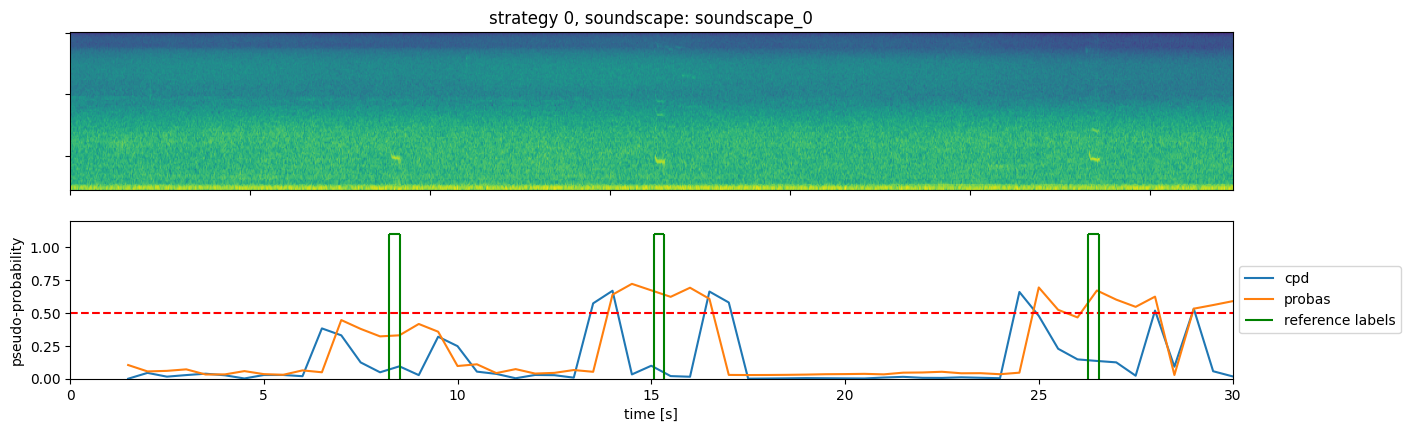

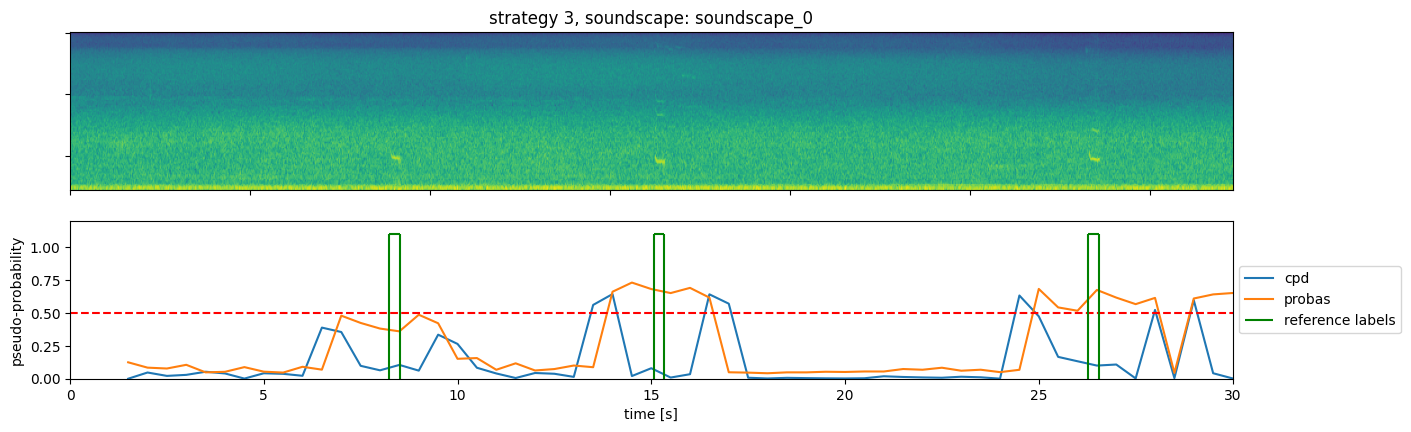

In [129]:
# visualize resulting model on test data
#snr = '0.0'
base_test_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME_forest_path/Q/test_soundscapes_snr_{}/'.format(snr)
query_strategy_0.base_dir = base_test_dir
query_strategy_1.base_dir = base_test_dir
query_strategy_2.base_dir = base_test_dir
query_strategy_3.base_dir = base_test_dir
all_test_soundscape_basenames = ['soundscape_{}'.format(idx) for idx in range(n_soundscapes)]

soundscape_basename = all_test_soundscape_basenames[0]

n_queries = 7
visualize.visualize_query_strategy(query_strategy_0, "strategy 0", soundscape_basename, base_test_dir, n_queries=n_queries, vis_queries=False)
#visualize.visualize_query_strategy(query_strategy_1, "strategy 1", soundscape_basename, base_test_dir, n_queries=n_queries)
#visualize.visualize_query_strategy(query_strategy_2, "strategy 2", soundscape_basename, base_test_dir, n_queries=n_queries)
visualize.visualize_query_strategy(query_strategy_3, "strategy 3", soundscape_basename, base_test_dir, n_queries=n_queries, vis_queries=False)

In [61]:
# TODO: maybe I need a better measure of label-quality, the measure needs to be soft
# without any matching. This measure may miss the important differences.
print("Fix  queries, f1 = {:.3f}, miou = {:.3f}".format(fix_f1_means[0], fix_iou_means[0]))
print("AL   queries, f1 = {:.3f}, miou = {:.3f}".format(al_f1_means[0], al_iou_means[0]))
print("Opt. queries, f1 = {:.3f}, miou = {:.3f}".format(1.0, 1.0))

Fix  queries, f1 = 0.850, miou = 0.035
AL   queries, f1 = 0.898, miou = 0.050
Opt. queries, f1 = 1.000, miou = 1.000


Text(0.5, 0, 'number of queries per soundscape')

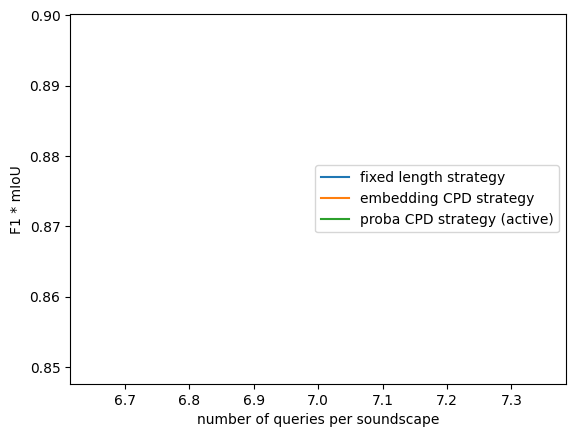

In [18]:
plt.plot(n_queriess, fix_means, label='fixed length strategy')
plt.plot(n_queriess, cp_means, label='embedding CPD strategy')
#plt.plot(n_queriess, al_means_fix, label='proba CPD strategy (passive)')
plt.plot(n_queriess, al_means, label='proba CPD strategy (active)')
plt.legend()
plt.ylabel('F1 * mIoU')
plt.xlabel('number of queries per soundscape')

In [78]:
def annotator_cost(start_time, end_time, cost_linear, cost_overhead):
    segment_cost = (end_time - start_time) * cost_linear + cost_overhead
    return segment_cost

def cost_of_queries(queries, cost_linear, cost_overhead):
    cost = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in queries])
    return cost

# def pos_events_from_queries(queries, oracle, soundscape_basename):
#     pos_events = []
#     for (q_st, q_et) in queries:
#         c = oracle.query(q_st, q_et, soundscape_basename)
#         if c == 1:
#             pos_events.append((q_st, q_et))
#     return pos_events

base_dir = '../soundscapes/ME/test'
soundscape_basename = 'ME1'

ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
me1_pos_ref = datasets.load_pos_ref(ref_path)
me1_neg_ref = datasets.load_neg_ref(ref_path, 30)

oracle = oracles.WeakLabelOracle(base_dir = base_dir)
min_iou = 0.0

annotations = me1_pos_ref + me1_neg_ref
annotations = sorted(annotations, key=lambda x: x[0])
annotations = qs.load_query_ref(ref_path, soundscape_length=30)
#annotations = [(0, annotations[0][0])] + annotations
adp_queries = []

min_query_length = 1
max_query_length = 60

idx_ann = 0
end_time = annotations[-1][1]
create_query = True
while create_query:
    (ann_start_time, ann_end_time) = annotations[idx_ann]
    l = ann_end_time - ann_start_time
    
    if l < min_query_length:
        query_start_time = ann_start_time
        query_end_time = query_start_time + min_query_length
        q = (query_start_time, query_end_time)

        if query_end_time > end_time:
            pop = False
            create_query = False
        else:
            pop = True
        adp_queries.append(q)

        while pop:
            ann_end_time = annotations[idx_ann][1]
            if ann_end_time < query_end_time:
                idx_ann += 1
            else:
                pop = False
    else:
        q = (ann_start_time, ann_end_time)
        adp_queries.append(q)
    idx_ann += 1
    if idx_ann >= len(annotations):
        create_query = False
        
# adjust queries    
add_queries = []
for idx_q in range(len(adp_queries)-1):
    q1 = adp_queries[idx_q]
    q2 = adp_queries[idx_q + 1]

    l = q2[0] - q1[1]
    if l < min_query_length:
        adp_queries[idx_q] = (q1[0], q2[0])
    else:
        q = (q1[1], q2[0])
        add_queries.append(q)

adp_queries = adp_queries + add_queries
adp_queries = sorted(adp_queries, key = lambda x: x[0])

cost_overhead = 10
cost_linear = 1

me1_pos_pred = oracle.pos_events_from_queries(adp_queries, soundscape_basename)
print("f1 score (adaptive) : ", metrics.f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou))
print("cost     (adaptive) : ", cost_of_queries(adp_queries, cost_linear=cost_linear, cost_overhead=cost_overhead))

fix_queries = np.linspace(0, 536, int(536/min_query_length))
fix_queries = list(zip(fix_queries[:-1], fix_queries[1:]))
me1_pos_pred = oracle.pos_events_from_queries(fix_queries, soundscape_basename)
print("f1 score (fixed)    : ", metrics.f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou))
print("cost     (fixed)    : ", cost_of_queries(fix_queries, cost_linear=cost_linear, cost_overhead=cost_overhead))

f1 score (adaptive) :  0.8571428571428571
cost     (adaptive) :  756.097
f1 score (fixed)    :  0.8148148148148148
cost     (fixed)    :  5886.0


# Change-point detection

peaks (cosine distance)       :  [7, 10, 2, 5]
prominences (cosine distance) :  [0.29289321881345254, 0.29289321881345254, 0.22527465152822135, 0.22527465152822135]


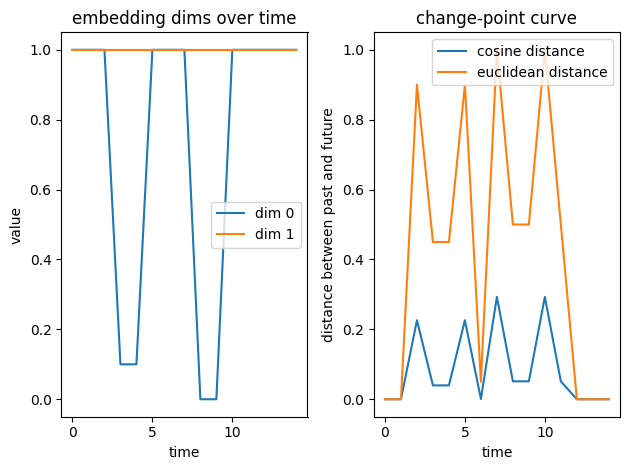

In [79]:
peaks, prominences = cpd.test_change_point_detection()

timings:  (59, 2)
embeddings:  (59, 1024)
[7.5, 11.5, 15.5, 20.0, 26.5]


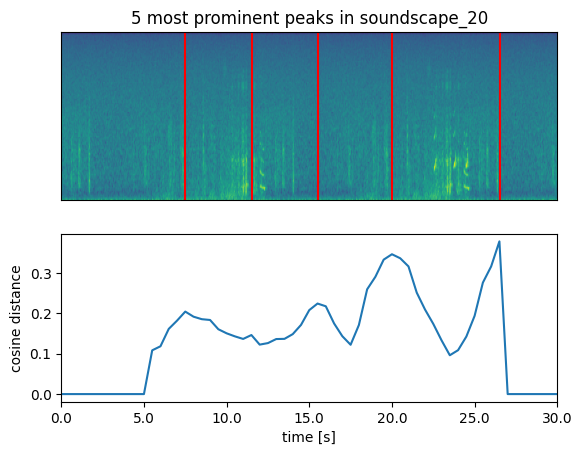

In [80]:
base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_soundscapes_snr_10.0/'
soundscape_basename = 'soundscape_20'
embedding_path = os.path.join(base_dir, '{}.birdnet.embeddings.txt'.format(soundscape_basename))

timings_and_embeddings = datasets.load_timings_and_embeddings(
    file_path=embedding_path,
    embedding_dim=1024
)

timings    = np.array([[s, e] for (s, e, _) in timings_and_embeddings])
embeddings = np.array([r for (_, _, r) in timings_and_embeddings])
print("timings: ", timings.shape)
print("embeddings: ", embeddings.shape)

M = 3
n_peaks = 5
peaks, ds = cpd.change_point_detection_from_embeddings(
    embeddings,
    timings,
    M = M,
    prominence = 0,
    n_peaks = n_peaks,
)

emb_window_length = 3.0
emb_hop_length = 0.5

# align in time
time_align = int(np.ceil((emb_window_length / 2) / emb_hop_length))
time_aligned_ds = np.concatenate((np.zeros(time_align), ds[:-1]))

# extract Mel spectrogram
wave, sr = librosa.load(os.path.join(base_dir, soundscape_basename + ".wav"))
window_length = 0.025
n_fft = utils.next_power_of_2(int(sr * window_length))
mel_spectrogram = librosa.feature.melspectrogram(
    y=wave,
    sr=sr,
    n_fft = n_fft,
    hop_length = n_fft // 2,
)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(np.flip(np.log(mel_spectrogram + 1e-10), axis=0), aspect='auto')
ax[0].set_title("{} most prominent peaks in {}".format(n_peaks, soundscape_basename))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].plot(time_aligned_ds, label='prediction')
ax[1].set_xlim(0, len(time_aligned_ds)-1)
ax[1].set_ylabel('cosine distance')
ax[1].set_xlabel('time [s]')

xticks = ax[1].get_xticks()
xtickslabels = np.linspace(0, 30, len(xticks))
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xtickslabels)

N = mel_spectrogram.shape[1]
dt = 30 / N

print(peaks)
peak_frame_indices = [int(c / dt) for c in peaks]

for peak_frame_idx in peak_frame_indices:
    ax[0].axvline(peak_frame_idx, color='red')

In [90]:
soundscape_basename = 'soundscape_16'
soundscape_length = qs.get_soundscape_length(base_dir, soundscape_basename)
opt_queries = qs.optimal_query_strategy(base_dir, soundscape_basename, soundscape_length)
print(opt_queries)

[(0, 2.261777842309625), (2.261777842309625, 2.391777842309625), (2.391777842309625, 10.461136225085408), (10.461136225085408, 10.565136225085407), (10.484513092515307, 10.70353392584864), (10.565136225085407, 10.484513092515307), (10.70353392584864, 30.0)]


In [94]:
ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
pos_ref = datasets.load_pos_ref(ref_path)
pos_ref

[(2.261777842309625, 2.391777842309625),
 (10.461136225085408, 10.565136225085407),
 (10.484513092515307, 10.70353392584864)]

In [111]:
ls = np.concatenate(cp_lengths)
print("mean: ", np.mean(ls))
print("median: ", np.median(ls))
print("min: ", np.min(ls))
print("max: ", np.max(ls))
#print(np.sum(ls < 2))

mean:  7.009345794392523
median:  6.0
min:  2.0
max:  23.0


# Real soundscape

In [73]:
base_dir = '../soundscapes/ME/train/'
soundscape_basename = 'ME2'
xs = np.arange(1, 200, 10)
fix_ys = []
cp_ys = []
for idx, n_queries in tqdm.tqdm(enumerate(xs)):
    soundscape_length = qs.get_soundscape_length(base_dir, soundscape_basename)
    name_to_label_quality, n_opt_queries = evaluate.evaluate_all(base_dir, soundscape_basename, min_iou=0.01, n_queries=n_queries)
    fix_ys.append(name_to_label_quality['fix'])
    cp_ys.append(name_to_label_quality['cp'])

20it [00:09,  2.06it/s]


Text(0.5, 0, 'budget')

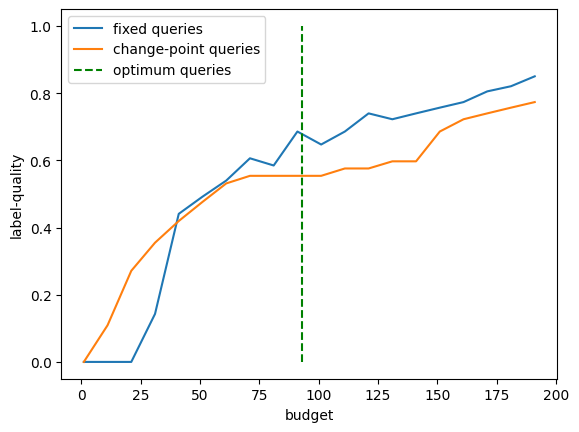

In [74]:
plt.plot(xs, fix_ys, label='fixed queries')
plt.plot(xs, cp_ys, label='change-point queries')
plt.vlines([n_opt_queries], ymin=0, ymax=1, color='green', linestyle='dashed', label='optimum queries')
plt.legend()
plt.ylabel('label-quality')
plt.xlabel('budget')

# OLD CODE

In [46]:
base_dir = '../soundscapes/ME/test'
soundscape_basename = 'ME1'

ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
me1_pos_ref = load_annotations(ref_path)
me1_neg_ref = compute_neg_ref(me1_pos_ref)

oracle = oracles.WeakLabelOracle(base_dir = base_dir)


file_end_time = me1_pos_ref[-1][1]

n_segment_lengths = 50
min_segment_length = 1
max_segment_length = 30
segment_lengths = np.linspace(min_segment_length, max_segment_length, n_segment_lengths)

n_cost_overheads = 50
min_cost_overhead = 0
max_cost_overhead = 20
cost_overheads = np.linspace(min_cost_overhead, max_cost_overhead, n_cost_overheads)

# label_quality_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))
# cost_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_fixed = np.zeros((n_segment_lengths, n_cost_overheads))
cost_fixed = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_oracle = np.zeros((n_segment_lengths, n_cost_overheads))
cost_oracle = np.zeros((n_segment_lengths, n_cost_overheads))


cost_linear = 1
min_iou = 0.01 #0.025 * 3

#segment_lengths = [1.0]
#cost_overheads = [100.0]

for idx_seg, segment_length in enumerate(segment_lengths):
    for idx_cost, cost_overhead in enumerate(cost_overheads):

        # ORACLE: compute cost of optimal query strategy (recovers true labels using weak-labels)
        cost_opt_query_pos = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_pos_ref])
        cost_opt_query_neg = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_neg_ref])
        cost_opt_query = cost_opt_query_neg + cost_opt_query_pos
        f1_opt = f1_score_from_events(me1_pos_ref, me1_pos_ref, min_iou=min_iou)

        # FIXED: compute cost of segment query strategy
        time_counter = 0.0
        cost_fix_query = 0.0
        me1_pos_pred = []
        
        # simulate annotation of the whole file
        while time_counter < file_end_time:
            query_start_time = time_counter
            query_end_time   = time_counter + (segment_length)
    
            # get annotation
            c = oracle.query(query_start_time, query_end_time, soundscape_basename)
            if c == 1:
                me1_pos_pred.append((query_start_time, query_end_time))
    
            # get cost
            cost = annotator_cost(query_start_time, query_end_time, cost_linear, cost_overhead)
            cost_fix_query += cost
    
            # increase time counter
            time_counter += segment_length

        f1 = f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou)

        # baseline
        label_quality_fixed[idx_seg, idx_cost] = f1
        cost_fixed[idx_seg, idx_cost] = cost_fix_query

        # oracle
        label_quality_oracle[idx_seg, idx_cost] = f1_opt
        cost_oracle[idx_seg, idx_cost] = cost_opt_query

        # bounded-oracle

(50, 50)
(50, 50)
0.43915399422756474


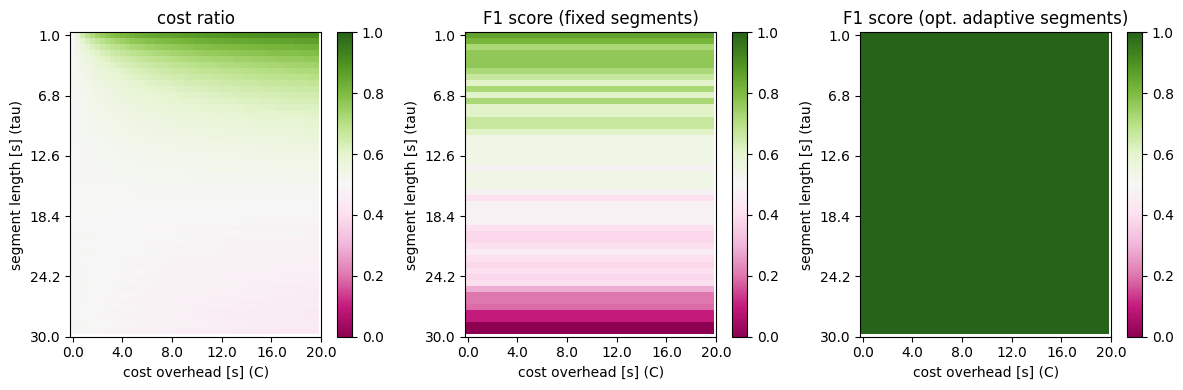

In [49]:
cost_ratio_result = cost_fixed / (cost_fixed + cost_oracle)
label_quality_ratio_result = label_quality_fixed #1 / (1 + label_quality_fixed)
print(label_quality_ratio_result.shape)
print(cost_ratio_result.shape)


cmap = matplotlib.colormaps['PiYG']

fig, ax = plt.subplots(1,3, figsize=(12,4))

img0 = ax[0].imshow(cost_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[0].set_title('cost ratio')
plt.colorbar(img0, ax=ax[0])

img1 = ax[1].imshow(label_quality_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[1].set_title('F1 score (fixed segments)')
plt.colorbar(img1, ax=ax[1])


img2 = ax[2].imshow(label_quality_oracle, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[2].set_title('F1 score (opt. adaptive segments)')
plt.colorbar(img2, ax=ax[2])

for idx in [0, 1, 2]:
    # set xticks
    xticks = ax[idx].get_xticks()[1:]
    #print(xticks)
    xticklabels = np.linspace(min_cost_overhead, max_cost_overhead, len(xticks))
    xticklabels = ['{:.1f}'.format(c) for c in xticklabels]
    #print(xticklabels)
    ax[idx].set_xticks(xticks)
    ax[idx].set_xticklabels(xticklabels)
    ax[idx].set_xlabel('cost overhead [s] (C)')
    
    # set yticks
    yticks = ax[idx].get_yticks()[1:]
    #print("y: ", yticks)
    yticklabels = np.linspace(min_segment_length, max_segment_length, len(yticks))
    yticklabels = ['{:.1f}'.format(c) for c in yticklabels]
    #print("yticklabels: ", yticklabels)
    ax[idx].set_yticks(yticks)
    ax[idx].set_yticklabels(yticklabels)
    ax[idx].set_ylabel('segment length [s] (tau)')

plt.tight_layout()
print(np.min(cost_ratio_result))

(2, 2)


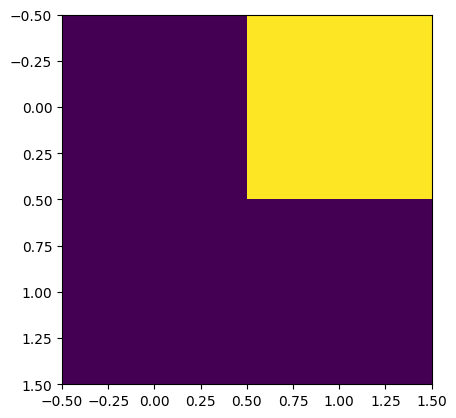

In [33]:
x = np.array([
    [0, 1],
    [0, 0]
])
print(x.shape)
plt.imshow(x)

In [8]:
# measure of label quality

# Baseline: fixed segment lengths
# simulate weak-labelling approach with fixed length segments
# 1. true label
# 2. sliding window with max

# compute cost of fixed length segment approach
# Oracle: optimal adaptive segment lengths
# compute cost of optimal adaptive segments approach

# Human: simulate sub-optimal adaptive segments approach, taking human characteristics into account
# 1. set minimum and maximum segment lengths
# 2. come up with reasonable heuristic
#     a. for all events shorter than min, place window on top of them
#     b. for all events longer than max, distribute window inside
#     c. for all remaining events, place optimal window on them
#     d. derive labels

# simulate annotator quality, if window overlaps too little with event, add label noise

# Figure 1. Label quality on y-axis, annotator cost on x-axis
# Baseline: plot this for different segment lengths, varying between minimum event length to maximum event length
# Oracle: plot this optimal point in figure. This is the least amount of annotation necessary (under the assumed cost model) to derive optimal labels.
# Human: plot this sub-optimal point in figure. This is approximately the least amount of annotation necessary to derive the sub-optimal labels.
#
# The idea of figure 1 is to convince the reader that the persuit of adaptive segmentation lengths can have benefits, 
# and to understand better under which scenarios it will have benefits. I think this is important.

# Things to vary.
#
# Annotator model. Different assumptions on label noise for sub-optimal overlap with event of interest.
# Cost model. Different assumptions on the constant overhead cost and the gradient for the linear cost.